In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    `# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## This is a experimental notebook for 'Focused Attention in Transformers for interpretable classification of retinal images'

paper link - https://www.sciencedirect.com/science/article/pii/S1361841522002377

datasets link - https://www.kaggle.com/datasets/paultimothymooney/kermany2018

sample code - https://github.com/ClementPla/FocusedAttention/blob/main/src/interpretable_VIT/focused_attention.py

In [ ]:
# Continue with regular imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

import os
import pathlib
from PIL import Image

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the modular directory, download it from GitHub if it doesn't work
try:
    from modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the modular scripts
    print("[INFO] Couldn't find modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/rkstu/FoodMini-Vision-Transformer
    !mv FoodMini-Vision-Transformer/modular .
    !mv FoodMini-Vision-Transformer/helper_functions.py . # get the helper_functions.py script
    !rm -rf FoodMini-Vision-Transformer
    from modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

### Setting device agnostic code

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Exploratory data analysis (EDA)

In [ ]:
# Chekout size of the input
import os
from PIL import Image

dir_names = ['train', 'test']
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
# source_dir = "retinal_cf_20_percent"
source_dir = "OCT2017"
for dir_name in dir_names:
    path = f'{source_dir}/{dir_name}'
    print(f"\nFor {dir_name} directory")
    for dirname, _, filenames in os.walk(path):
        if len(filenames) > 0:
            print(f'{len(filenames)} files in {dirname.split("/")[-1]}')


For train directory
37205 files in train\CNV
11348 files in train\DME
8616 files in train\DRUSEN
26315 files in train\NORMAL

For test directory
250 files in test\CNV
250 files in test\DME
250 files in test\DRUSEN
250 files in test\NORMAL


## Find subset of appropriate classes

In [ ]:
# Setup data directory
import pathlib
data_dir = pathlib.Path(f"{source_dir}")

data_dir / "train", str(data_dir / "train")

(WindowsPath('OCT2017/train'), 'OCT2017\\train')

=================================== Taking a subset of data ==================================

In [ ]:
# # Get random 20% of training images
# import random

# # Setup data paths
# target_classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
# data_splits = ['train', 'test']

# # Change amount of data to get (e.g. 0.01 = random 1%, 0.01 = random 1%)
# amount_to_get = 0.2
# # data_path = data_dir /

# # Create function to separate a random amount of data

# random.seed(42)
# label_splits = {}

# # Get labels
# for data_split in data_splits:
#     print(f"[INFO] Creating image split for: {data_split}...")
#     images = []

#     path = f'{source_dir}/{data_split}' # data_split = train , test
# #     print(os.path.isdir(path))
#     for dirname, _, filenames in os.walk(path):
#         for filename in filenames:
#             images.append(pathlib.Path(os.path.join(dirname, filename)))

#     # Get random subset of target classes image ID's
#     number_to_sample = round(amount_to_get * len(images))
#     print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
#     image_paths = random.sample(images, k=number_to_sample)

#     label_splits[data_split] = image_paths

# label_splits["train"][:5]

In [ ]:
# len(label_splits['train']), len(label_splits['test'])

## Move training and testing images to dedicated folders

In [ ]:
# # Create target directory path
# target_dir_name = f"retinal_cf_{str(int(amount_to_get*100))}_percent"
# print(f"Creating directory: '{target_dir_name}'")

# # Setup the directories
# target_dir = pathlib.Path(target_dir_name)

# # Make the directories
# target_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# import shutil

# for image_split in label_splits.keys():
#     for image_path in label_splits[str(image_split)]:
#         dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
#         if not dest_dir.parent.is_dir():
#             dest_dir.parent.mkdir(parents=True, exist_ok=True)
# #         print(f"[INFO] Copying {image_path} to {dest_dir}...")
#         shutil.copy2(image_path, dest_dir)

In [ ]:
# Chekout size of the working dataset
import os
from PIL import Image

dir_names = ['train', 'test']
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for dir_name in dir_names:
    path = f'{source_dir}/{dir_name}'
    print(f"\nFor {dir_name} directory")
    for dirname, _, filenames in os.walk(path):
        if len(filenames) > 0:
            print(f'{len(filenames)} files in {dirname.split("/")[-1]}')


For train directory
37205 files in train\CNV
11348 files in train\DME
8616 files in train\DRUSEN
26315 files in train\NORMAL

For test directory
250 files in test\CNV
250 files in test\DME
250 files in test\DRUSEN
250 files in test\NORMAL


In [ ]:
# setup directory for training and testing imaes
from pathlib import Path
data_dir = Path(source_dir)

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

train_dir, test_dir, os.path.isdir(train_dir), os.path.isdir(test_dir)

(WindowsPath('OCT2017/train'), WindowsPath('OCT2017/test'), True, True)

======================================== Till here ======================================

In [ ]:
train_dir = str(train_dir)
test_dir = str(test_dir)
train_dir, test_dir

('OCT2017\\train', 'OCT2017\\test')

In [ ]:
# train_dir = "OCT2017/train"
# test_dir = "OCT2017/test"
# train_dir, test_dir

Class Value Counts:
    Class  Count
0     CNV  37205
1     DME  11348
2  DRUSEN   8616
3  NORMAL  26315


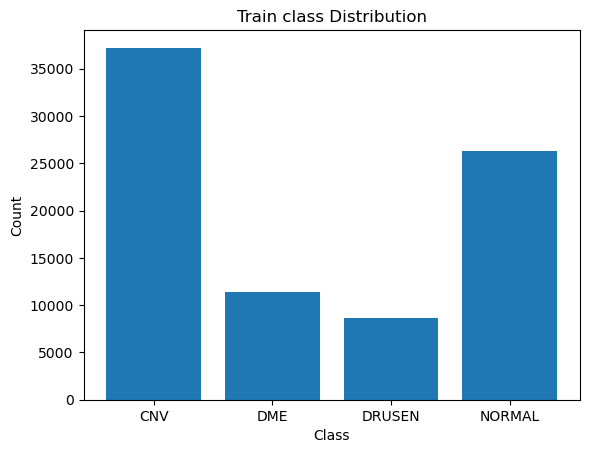

In [ ]:

# Path to the directory containing the class folders
train_data = str(train_dir)

# List of classes
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Create an empty dictionary to store the count of images in each class
class_counts = {}

# Count the number of images in each class
for class_name in classes:
    class_folder = os.path.join(train_data, class_name)
    files = os.listdir(class_folder)
    class_counts[class_name] = len(files)

# Convert the dictionary to a pandas DataFrame for better display
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Display the DataFrame
print("Class Value Counts:")
print(class_counts_df)

# Plot a bar chart for better visualization
plt.bar(class_counts_df['Class'], class_counts_df['Count'])
plt.title('Train class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Class Value Counts:
    Class  Count
0     CNV    250
1     DME    250
2  DRUSEN    250
3  NORMAL    250


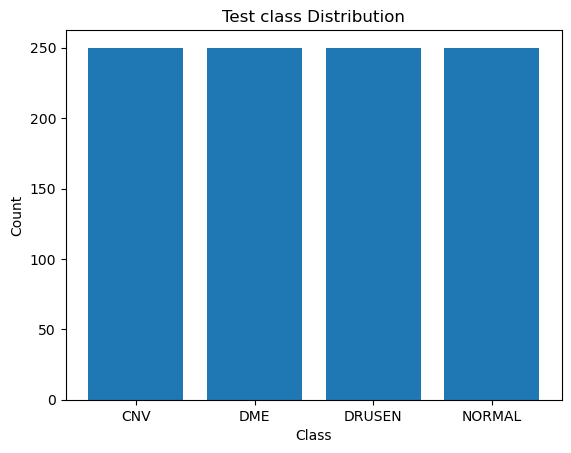

In [ ]:

# Path to the directory containing the class folders
test_data = str(test_dir)

# List of classes
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Create an empty dictionary to store the count of images in each class
class_counts = {}

# Count the number of images in each class
for class_name in classes:
    class_folder = os.path.join(test_data, class_name)
    files = os.listdir(class_folder)
    class_counts[class_name] = len(files)

# Convert the dictionary to a pandas DataFrame for better display
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Display the DataFrame
print("Class Value Counts:")
print(class_counts_df)

# Plot a bar chart for better visualization
plt.bar(class_counts_df['Class'], class_counts_df['Count'])
plt.title('Test class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 2. Create Datasets and DataLoader

### 2.1 Create transforms

Image input size : 384
and patch size : 16

source : from paper

In [ ]:
from torchvision import transforms

# Createa image
IMG_SIZE = 384  # according to the paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),  # Apply grayscale conversion
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=1)
    ToTensor()
)


### 2.2 Create dataloaders

Note: Another limitation regarding the proposed focused attention is its
inability to run on batches of images [Page 10]

In [ ]:
from modular.data_setup import create_dataloaders
import os

BATCH_SIZE = 1
num_workers = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=num_workers
                                                                    )
len(train_dataloader), len(test_dataloader), class_names

(83484, 1000, ['CNV', 'DME', 'DRUSEN', 'NORMAL'])

### 2.3 Visualize a single image from `train_dataloader`

Image batch shape: torch.Size([1, 1, 384, 384]) 
Label batch shape: torch.Size([1]) 
sample image shape: (torch.Size([1, 384, 384]), torch.float32) 
sample label shape: (torch.Size([]), torch.int64)


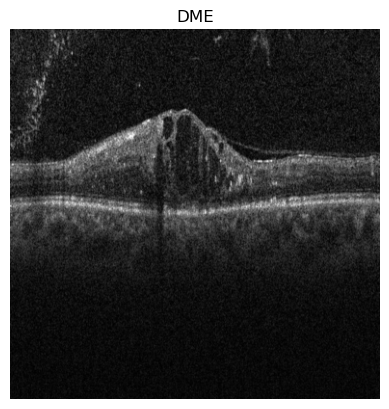

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
print(f'Image batch shape: {image_batch.shape} \nLabel batch shape: {label_batch.shape} ')

# Taking one image from train_dataloder
sample_image, sample_label = image_batch[0], label_batch[0]
print(f'sample image shape: {sample_image.shape, sample_image.dtype} \nsample label shape: {sample_label.shape, sample_label.dtype}')

# Ploting sample image with its label as title
plt.imshow(sample_image.permute(1, 2, 0), 'gray') # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[sample_label.item()])
plt.axis(False);

In [ ]:
# MODE: “L” (luminance) for greyscale images
from PIL import Image
im = Image.open("OCT2017/train/DME/DME-1072015-1.jpeg")
print(im.format, im.size, im.mode)

JPEG (512, 496) L


In [ ]:
num_of_color_channels = torchvision.transforms.functional.get_image_num_channels(sample_image)
num_of_color_channels

1

In [ ]:
sample_image.shape

torch.Size([1, 384, 384])

## 3. Replicating ViT: Overview

Looking at a whole machine learning resurch paper can be imtimidating

So in order to make it more understandable, we can break it down to smaller pieces
* **Inputs** - What goes into the model> (in out case, image tensor)
* **Outputs** -  What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks**  - A collection of layers.
* **Model (or architecture)** - A collection of blocks



#### Section 3.1 Describes various equation
**Equation 1**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocod:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```




## 4. Equation 1: Split data into patches and creating the class, position and path embedding

Layers = input->funciton->output

What's the input shape?

What's the output shape



In [ ]:
# Create example values
height = 384
width = 384
color_channels = num_of_color_channels
patch_size = 16

# Calculate the number of pathces
number_of_patches  = (height * width) / (patch_size**2)
number_of_patches

576.0

In [ ]:
# Input shape
embedding_layer_input_shape =  (height, width, color_channels)

# Output shape
(number_of_patches, embedding_dimension) = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patch): ({number_of_patches}, {embedding_dimension}) -> (number_of_patches, embedding_dimension)')

Input shape (single 2D image): (384, 384, 1)
Output shape (single 1D sequence of patch): (576.0, 256) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

(-0.5, 383.5, 383.5, -0.5)

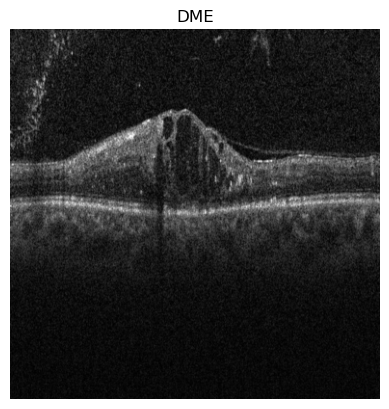

In [ ]:
# View a single image
plt.imshow(sample_image.permute(1, 2, 0), 'gray')
plt.title(class_names[sample_label.item()])
plt.axis(False)

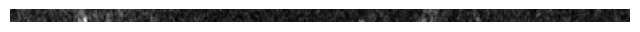

In [ ]:
# Get the top row of the image
image_permuted = sample_image.permute(1, 2, 0) # Convert image color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 8
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :], 'gray')
plt.axis(False);

Number of patches per row: 24.0
Patch size: 16 pixels x 16 pixels


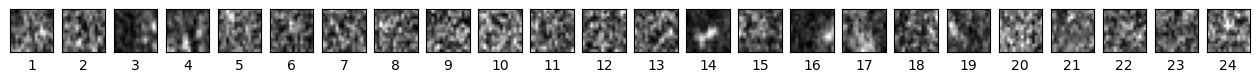

In [ ]:
# Setup code to plot top row as patches
img_size = 384
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by path_size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column each path
                        sharex=True,
                        sharey=False,
                        figsize=(patch_size, patch_size))

# Iterare through number of pathces in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :], 'gray');
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  # print(patch)

In [ ]:
# # Plot whole image as pathces
# # Setup code to plot top row as patches
# img_size = 256
# patch_size = 8
# num_patches = img_size / path_size
# assert img_size % path_size == 0, "Image size must be divisible by path_size"
# print(f'Number of patches per row: {num_patches}\nNumber of patches per Col: {num_patches}\nPatch size: {path_size} pixels x {patch_size} pixels')

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size, # one row each path
#                         ncols=img_size // patch_size, # one column each path
#                         sharex=True,
#                         sharey=False,
#                         figsize=(path_size, path_size))

# # Iterare through number of pathces in the top row
# for i, patch_height in enumerate(range(0, img_size, path_size)):
#   for j, patch_width in enumerate(range(0, img_size, path_size)):
#     axs[i, j].imshow(image_permuted[patch_height:patch_height+path_size, patch_width:patch_width+path_size, :]);

#     # Setup label information for each subplot (patch)
#     axs[i, j].set_ylabel(i+1,
#                          rotation="horizontal",
#                          horizontalalignment="right",
#                          verticalalignment="center")
#     axs[i, j].set_xlabel(j+1)
#     axs[i, j].set_xticks([])
#     axs[i, j].set_yticks([])
#     axs[i, j].label_outer()
#   # setup a title for the plot
#   fig.suptitle(f'{class_names[sample_label.item()]} -> Patchified', fontsize=14)

### 4.3 Creating image pathces and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.conv2d()` and setting the kernel size and stide parameters to `path_size`

In [ ]:
# Create conv2d layer to turn image into patches of learnable features maps (embeddings)
from torch import nn

# Set the patchsize
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(in_channels=num_of_color_channels, # color channels
                   out_channels=embedding_dimension, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(1, 256, kernel_size=(16, 16), stride=(16, 16))

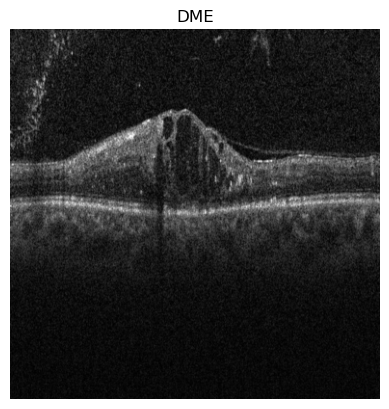

In [ ]:
# View single image
plt.imshow(sample_image.permute(1, 2, 0), 'gray')
plt.title(class_names[sample_label.item()])
plt.axis(False);

In [ ]:
# Pass the image though the convouational layer
image_out_of_conv = conv2d(sample_image.unsqueeze(dim=0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 256, 24, 24])


Now we've passed a single image to our `conv2d` layer, it's shape is

```python
torch.Size([1, 256, 24, 24]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional features maps from indexes: [151, 16, 153, 81, 224]


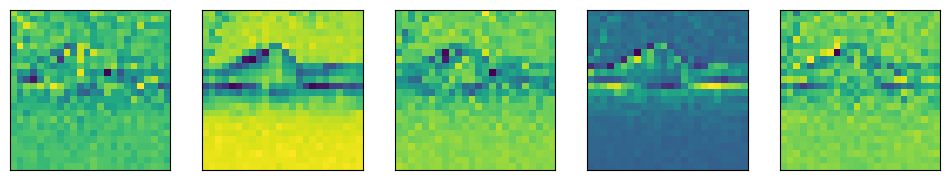

In [ ]:
# Plot random convolutional feature  maps (embeddings)
import random
random_indexes = random.sample(range(0, embedding_dimension), k = 5)
print(f'Showing random convolutional features maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad, single_feature_map.shape

(torch.Size([1, 24, 24]), True, torch.Size([1, 24, 24]))

 ### 4.4 Flattening the patch embeddings with `torch.nn.Flatten()`

 Right now we have a series of convolutional feature maps(patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input cretaria of out ViT Transformer Emcoder

In [ ]:
print(f'{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]')

torch.Size([1, 256, 24, 24]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: [batch_size, number_of_patches, embedding_dim]

In [ ]:
result = torch.flatten(image_out_of_conv, start_dim=2, end_dim=3)

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 256, 576])

Original image shape: torch.Size([1, 384, 384])
Image feature map (patches) shape: torch.Size([1, 256, 24, 24])
Flattend image feature map shape: torch.Size([1, 256, 576])


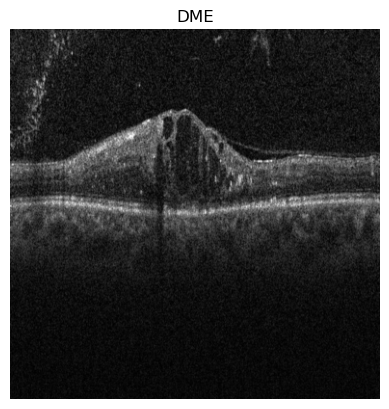

In [ ]:
# Put everything together
plt.imshow(sample_image.permute(1, 2, 0), 'gray')
plt.title(class_names[sample_label.item()])
plt.axis(False)
print(f'Original image shape: {sample_image.shape}')

# Turn image into feature image
image_out_ofOconv = conv2d(sample_image.unsqueeze(dim=0)) # adding a batch dim
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature map
image_out_of_conv_flattend = flatten_layer(image_out_of_conv)
print(f'Flattend image feature map shape: {image_out_of_conv_flattend.shape}')

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattend_permuted = image_out_of_conv_flattend.permute(0, 2, 1)
print(f'{image_out_of_conv_flattend_permuted.shape} -> (batch_size, patch_size, embedding_dim')

torch.Size([1, 576, 256]) -> (batch_size, patch_size, embedding_dim


In [ ]:
image_out_of_conv_flattend.requires_grad

True

torch.Size([1, 576]) True


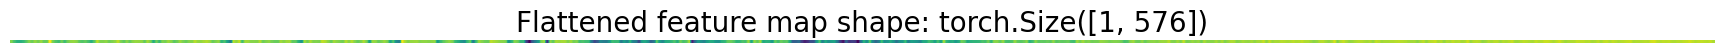

In [ ]:
# Get a single flattend feature map
single_flattened_feature_map = image_out_of_conv_flattend_permuted[:, :, 0]
print(single_flattened_feature_map.shape, single_flattened_feature_map.requires_grad)

# Plot the flattend feature map visaully
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}', fontsize=20)
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparamters, such as channels, embedding dimension, path size,
3. Create a layer to turn image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the reuired output shape of the embeddings.

In [ ]:
# 1. Creating
class PatchEmbedding(nn.Module):
  # 2. Create a conv2d layer with hyperparameters from ViT paper
  def __init__(self, in_channels:int=3, embedding_dim:int=768, patch_size:int=16):
    super().__init__()
    self.patch_size = patch_size
    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels, # color channels
                          out_channels=embedding_dim, # D size from Table 1
                          kernel_size=patch_size,
                          stride=patch_size,
                          padding=0)
    # 4. Flatten layer
    self.flatten_layer = nn.Flatten(start_dim=2,
                                    end_dim=3)
  # 5. Define foward
  def forward(self, x:torch.Tensor) -> torch.Tensor():
    # Create asserion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by path_size, image shape: {image_resolution}, patch size: {self.patch_size}'
    return self.flatten_layer(self.patcher(x)).permute(0, 2, 1)


In [ ]:
number_of_patches, embedding_dimension

(576.0, 256)

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=num_of_color_channels,
                          patch_size=16,
                          embedding_dim=embedding_dimension)

# Pass a single image through path embedding layer
print(f'Input image size: {sample_image.unsqueeze(dim=0).shape}') # adding a batch dim
patch_embedded_image = patchify(sample_image.unsqueeze(dim=0))
print(f'Output patch embeddings size: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 1, 384, 384])
Output patch embeddings size: torch.Size([1, 576, 256])


In [ ]:
# Just for testing input oputput of patchify functino
rand_image_tensor = torch.randn(1, 1, 384, 384)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor).shape

torch.Size([1, 576, 256])

### 4.6 Creating the class token emebedding

Want to: prepend a learnable class token to start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.0794, -0.0639,  0.0195,  ..., -0.0041,  0.0162,  0.0378],
         [-0.0474, -0.0319,  0.0522,  ...,  0.0595, -0.0076, -0.0161],
         [-0.1979, -0.0250, -0.0314,  ..., -0.0174,  0.0475,  0.0758],
         ...,
         [ 0.0181,  0.0199,  0.0490,  ...,  0.0348,  0.0332, -0.0212],
         [ 0.0165,  0.0321,  0.0310,  ...,  0.0282,  0.0441, -0.0275],
         [-0.0091,  0.0157,  0.0360,  ...,  0.0371,  0.0408, -0.0349]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 256)

In [ ]:
# Create class token embedding as a learnable parameters that shares the same size as the embedded dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 256])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 576, 256])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedding_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension
print(patch_embedding_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedding_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0794, -0.0639,  0.0195,  ..., -0.0041,  0.0162,  0.0378],
         [-0.0474, -0.0319,  0.0522,  ...,  0.0595, -0.0076, -0.0161],
         ...,
         [ 0.0181,  0.0199,  0.0490,  ...,  0.0348,  0.0332, -0.0212],
         [ 0.0165,  0.0321,  0.0310,  ...,  0.0282,  0.0441, -0.0275],
         [-0.0091,  0.0157,  0.0360,  ...,  0.0371,  0.0408, -0.0349]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 577, 256]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embedding and to add them to the sequence of patch embeddings

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedding_image_with_class_embedding.shape

torch.Size([1, 577, 256])

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedding_image_with_class_embedding.shape[-1]

# Creating the learnable 1D embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 577, 256]))

In [ ]:
# Add the position embedding to the patch and class token  embedding
patch_and_position_embedding = patch_embedding_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9206, 0.9361, 1.0195,  ..., 0.9959, 1.0162, 1.0378],
         [0.9526, 0.9681, 1.0522,  ..., 1.0595, 0.9924, 0.9839],
         ...,
         [1.0181, 1.0199, 1.0490,  ..., 1.0348, 1.0332, 0.9788],
         [1.0165, 1.0321, 1.0310,  ..., 1.0282, 1.0441, 0.9725],
         [0.9909, 1.0157, 1.0360,  ..., 1.0371, 1.0408, 0.9651]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 577, 256])


## 4.8 Putting it all together from image to embidding

We've written code to turn an image into a flattened sequence of patch embeddings.

In [ ]:
# Set seed
set_seeds()


# 1. Set patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f'Image tensor shape: {sample_image.shape}')
height, width = sample_image.shape[1], sample_image.shape[2]

# 3. Get image tensor and add a batch dimension
x = sample_image.unsqueeze(dim=0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=num_of_color_channels,
                                       embedding_dim=embedding_dimension,
                                       patch_size=patch_size)

# 5. Pass input image thorugh PathEmbedding
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's ilearnable
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shapes: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + patch_and_position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([1, 384, 384])
Input image shape: torch.Size([1, 1, 384, 384])
Patch embedding shape: torch.Size([1, 576, 256])
Class token embedding shape: torch.Size([1, 1, 256])
Patch embedding with class token shapes: torch.Size([1, 577, 256])
Patch and position embedding shape: torch.Size([1, 577, 256])


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA block" for short)
  """
  def __init__(self,
               embedding_dim:int, # Hidden size D (embedding dimension) from Tabel 1 for ViT-Base
               num_heads:int=12, # Heads form Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()

    # Create a norm layer (LN)
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create mutihead attention (MSA) layer
    self.multihead_attn_layer = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  def forward(self, x):
    x = self.norm_layer(x)
    attn_output, _ = self.multihead_attn_layer(query=x,
                                               key=x,
                                               value=x,
                                               need_weights=False)
    return attn_output

In [ ]:
 # Create n instance of MSA block
 multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dimension,
                                                              num_heads=8,
                                                              attn_dropout=0)

 # Pass the patch and position image embedding sequence though MSA block
 patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
 print(f'Input shape of MAS block: {patch_and_position_embedding.shape}')
 print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')


Input shape of MAS block: torch.Size([1, 577, 256])
Output shape of MSA block: torch.Size([1, 577, 256])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    return self.mlp(self.norm_layer(x))

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=embedding_dimension,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MLPBlock through the MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 577, 256])
Output shape of MLP block: torch.Size([1, 577, 256])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transfomerer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [ ]:
(384 / 16) ** 2

576.0

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                   num_heads=8)

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, number_of_patches, embedding_dimension), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

D:\Rahul_MCA\rahulenv\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 576, 256]        [1, 576, 256]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 576, 256]        [1, 576, 256]        --                   True
│    └─LayerNorm (norm_layer)                           [1, 576, 256]        [1, 576, 256]        512                  True
│    └─MultiheadAttention (multihead_attn_layer)        --                   [1, 576, 256]        263,168              True
├─MLPBlock (mlp_block)                                  [1, 576, 256]        [1, 576, 256]        --                   True
│    └─LayerNorm (norm_layer)                           [1, 576, 256]        [1, 576, 256]        512                  True
│    └─Sequential (mlp)                                 [1, 576, 256]        [1, 576, 256]        --                   True
│  

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [ ]:
# Create the same as above with torch.nn TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dimension, # embedding_size from table 1
                                                             nhead=8, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, number_of_patches, embedding_dimension), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 576, 256]        [1, 576, 256]        1,840,384            True
Total params: 1,840,384
Trainable params: 1,840,384
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.59
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.59

## 8. Putting it all together to create ViT

In [ ]:
# Create a ViT Class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=384, # Table 3 form ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT Base
               mlp_size:int=3073, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000 # number of classes in our classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with path size
    assert img_size % patch_size == 0, f'Image size must be division by path_size, image size: {img_size}, patch size: {patch_size}'

    # Calculate the number of patches (height * width / patch_size**2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (neeeds to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                          requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embidding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                         patch_size=patch_size,
                                         embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create clssifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Getting the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches + 1, embedding_dim)

    # Add position embedding to class
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directy after adding positional- tp patch embedding")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [ ]:

batch_size = 1
embidding_dim = embedding_dimension
class_embedding = nn.Parameter(data=torch.randn(1, 1, embidding_dim),
                               requires_grad = True)
class_embedding_expand = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expand.shape)

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])


In [ ]:
vit = ViT(img_size=384,
         in_channels=num_of_color_channels,
         num_transformer_layers=14,
         embedding_dim=embedding_dimension,
         num_heads=8,
         num_classes=4)
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(1, 256, kernel_size=(16, 16), stride=(16, 16))
    (flatten_layer): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (norm_layer): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (multihead_attn_layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (norm_layer): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=3073, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3073, out_features=256, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
    

In [ ]:
# Passing sample data
print(sample_image.shape)

output = vit(sample_image.unsqueeze(dim=0))
print(f'Output shape: {output.shape}')

torch.Size([1, 384, 384])
Output shape: torch.Size([1, 4])


In [ ]:
set_seeds()

# Create a random image tensor image tensor with same shape as a single shape
random_image_tensor = torch.randn(1, 1, 384, 384)

# Create a instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(img_size=384,
         in_channels=num_of_color_channels,
         num_transformer_layers=14,
         embedding_dim=embedding_dimension,
         num_heads=8,
         num_classes=4)

# Pass the random image tensor
result = vit(random_image_tensor)
result, result.shape

(tensor([[ 0.5690,  0.2973,  1.2625, -1.1633]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 4]))

### 8.1 Getting a visual summary of our ViT model

In [ ]:
class_names

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
#  # Get a summary using torchinfo.summary
# from torchinfo import summary
set_seeds()

vit = ViT(img_size=384,
         in_channels=num_of_color_channels,
         num_transformer_layers=24,
         embedding_dim=embedding_dimension,
         num_heads=16,
         num_classes=4)

summary(model=vit,
        input_size=(1, 1, 384, 384), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 1, 384, 384]     [1, 4]               147,968              True
├─PatchEmbedding (patch_embedding)                                [1, 1, 384, 384]     [1, 576, 256]        --                   True
│    └─Conv2d (patcher)                                           [1, 1, 384, 384]     [1, 256, 24, 24]     65,792               True
│    └─Flatten (flatten_layer)                                    [1, 256, 24, 24]     [1, 256, 576]        --                   --
├─Dropout (embedding_dropout)                                     [1, 577, 256]        [1, 577, 256]        --                   --
├─Sequential (transformer_encoder)                                [1, 577, 256]        [1, 577, 256]        --                   True
│    └─TransformerEncoderBlock (0)                           

## 9. Setting up training code for our custom ViT

Let's see how it performs on OCT2017 mini data


### 9.1 Creating an optimizer

The paper states it uses the Adamax optimizer (Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and learning rate of 0.0002.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [ ]:
import torch.optim as optim
# optimizer = torch.optim.Adam(params=vit.parameters(),
#                              lr=0.001,
#                              betas=(0.9, 0.999),
#                              weight_decay=0.1)
optimizer = torch.optim.Adamax(params=vit.parameters(),
                               lr=0.0002,
                               betas=(0.9, 0.999),
                               eps=1e-08, weight_decay=0)

# Create the optimizer using Stochastic Gradient Descent with Nesterov momentum
# optimizer = torch.optim.SGD(
#     params=vit.parameters(),
#     lr=0.0001,
#     momentum=0.9,
#     nesterov=True,
# )

### 9.3 Creating Loss functions

The ViT paper doesn't actually mention what loss function they used.

But since its a multiclass classification problem we'll use the `torch.nn.CrossEntropyLoss()`

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### Creating custom transform and dataloaders

In [ ]:
#### from torchvision import transforms

# Createa image
IMG_SIZE = 384  # according to the paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.Resize(size=(384, 384), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=384),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust mean and std for grayscale
])


print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=[0.485], std=[0.229])
)


In [ ]:
from modular.data_setup import create_dataloaders
import os

BATCH_SIZE = 18
num_workers = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=num_workers
                                                                    )
len(train_dataloader), len(test_dataloader), class_names

(4638, 56, ['CNV', 'DME', 'DRUSEN', 'NORMAL'])

### 9.3 Train the model

In [ ]:
from modular.engine import train

results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9858 | train_acc: 0.5999 | test_loss: 0.9619 | test_acc: 0.5438
Epoch: 2 | train_loss: 0.6617 | train_acc: 0.7480 | test_loss: 0.5955 | test_acc: 0.7708
Epoch: 3 | train_loss: 0.5291 | train_acc: 0.8012 | test_loss: 0.5297 | test_acc: 0.7867
Epoch: 4 | train_loss: 0.4457 | train_acc: 0.8351 | test_loss: 0.3884 | test_acc: 0.8512
Epoch: 5 | train_loss: 0.3899 | train_acc: 0.8576 | test_loss: 0.2574 | test_acc: 0.9107
Epoch: 6 | train_loss: 0.3504 | train_acc: 0.8733 | test_loss: 0.1732 | test_acc: 0.9496
Epoch: 7 | train_loss: 0.3145 | train_acc: 0.8876 | test_loss: 0.1745 | test_acc: 0.9395
Epoch: 8 | train_loss: 0.2850 | train_acc: 0.8995 | test_loss: 0.1342 | test_acc: 0.9583
Epoch: 9 | train_loss: 0.2607 | train_acc: 0.9069 | test_loss: 0.1351 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.2368 | train_acc: 0.9161 | test_loss: 0.0921 | test_acc: 0.9732


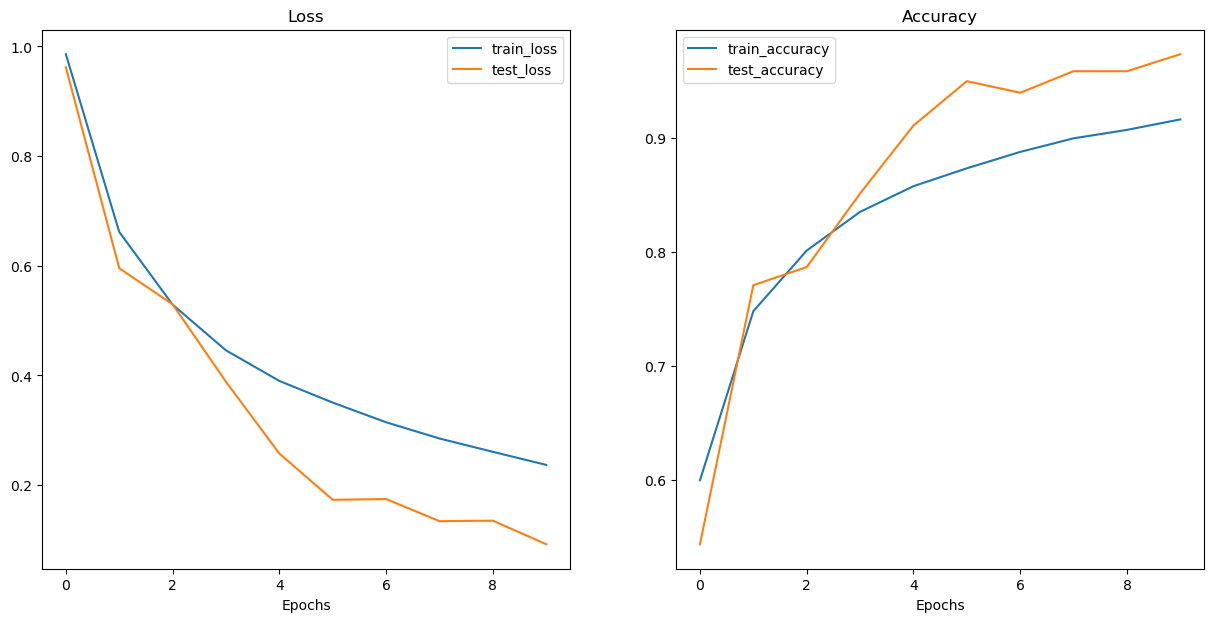

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

### 9.4 Save our best performing ViT model

In [ ]:
# Save the model
from modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="oct_model_b18.pth")

[INFO] Saving model to: models\oct_model_b18.pth


In [ ]:
from pathlib import Path

model_size = Path("models/oct_model_b18.pth").stat().st_size // (1024*1024)
print(f'Custom ViT model size: {model_size} MB')

Custom ViT model size: 169 MB


In [ ]:
set_seeds()

model = ViT(img_size=384,
         in_channels=1,
         num_transformer_layers=24,
         embedding_dim=256,
         num_heads=16,
         num_classes=4)


In [ ]:
os.path.exists("models")

True

In [ ]:
model.load_state_dict(torch.load("models/oct_model_b18.pth"))

<All keys matched successfully>

In [ ]:
summary(model=model,
        input_size=(1, 1, 384, 384), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 1, 384, 384]     [1, 4]               147,968              True
├─PatchEmbedding (patch_embedding)                                [1, 1, 384, 384]     [1, 576, 256]        --                   True
│    └─Conv2d (patcher)                                           [1, 1, 384, 384]     [1, 256, 24, 24]     65,792               True
│    └─Flatten (flatten_layer)                                    [1, 256, 24, 24]     [1, 256, 576]        --                   --
├─Dropout (embedding_dropout)                                     [1, 577, 256]        [1, 577, 256]        --                   --
├─Sequential (transformer_encoder)                                [1, 577, 256]        [1, 577, 256]        --                   True
│    └─TransformerEncoderBlock (0)                           

In [ ]:
from typing import List

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.
    """

    # 1. Load the image using PIL
    target_image_pil = Image.open(image_path).convert("RGB")

    # 2. Apply any necessary transformations
    if transform:
        target_image = transform(target_image_pil)
    else:
        target_image = torchvision.transforms.ToTensor()(target_image_pil)

    # 3. Add batch dimension and move to the target device
    target_image = target_image.unsqueeze(0).to(device)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Set model to evaluation mode and perform inference
    model.eval()
    with torch.no_grad():
        target_image_pred = model(target_image)

    # 6. Convert logits to probabilities and get the predicted label
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 7. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image_pil)
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.item()} | Prob: {target_image_pred_probs.max().item():.3f}"
    plt.title(title)
    plt.axis(False)
    plt.show()


In [ ]:
class_names

['CNV', 'DME', 'DRUSEN', 'NORMAL']

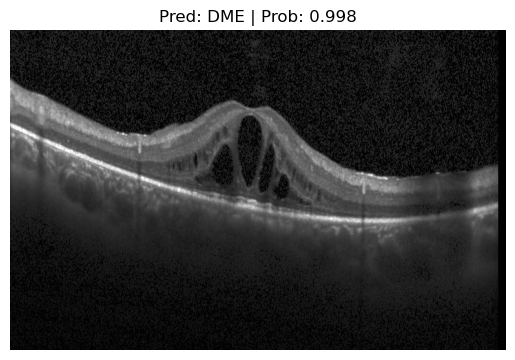

In [ ]:
custom_image_path = "OCT2017/test/DME/DME-1102486-1.jpeg"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                   transform=manual_transforms)

In [ ]:
import os
os.getcwd()

'D:\\Rahul_MCA'

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# from torchsummary import summary  # for model summary
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use weighted average for multiclass precision
    recall = recall_score(y_true, y_pred, average='weighted')        # Use weighted average for multiclass recall

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate specificity for each class
    num_classes = cm.shape[0]
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, 0), i, 1))  # Sum of true negatives excluding current class
        fp = np.sum(cm[:, i]) - cm[i, i]                    # Sum of false positives for current class
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)

    return accuracy, precision, recall, specificity


In [ ]:
# Example usage
test_data = ImageFolder('OCT2017/test', transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


accuracy1, precision1, recall1, specificity1 = evaluate_model(model, test_dataloader, device)

# params1, macs1 = calculate_model_complexity(vit)

# Assuming specificity is a list of values (one for each class)
print("Model 1 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
    accuracy1, precision1, recall1))
print("Model 1 - Specificity for each class:")
for i, spec in enumerate(specificity1):
    print(f"Class {class_names[i]}: {spec:.4f}")


Model 1 - Accuracy: 0.9730, Precision: 0.9735, Recall: 0.9730
Model 1 - Specificity for each class:
Class CNV: 0.9840
Class DME: 0.9973
Class DRUSEN: 0.9947
Class NORMAL: 0.9880
